In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=302)

# Don't forget to also split into a validation set!

In [2]:
# First, always look at your dataset shapes. It looks like dimension 0 are our samples (15480), and dimension 1 are our variables (8).
X_train.shape

(15480, 8)

In [3]:
# To access a single varialbe from the train dataset:
X_train[:, 0]
# Where the ":" means we get everything from this dimension (all samples), and the first (index 0) entry from the second dimension.

array([3.3409, 4.    , 4.1997, ..., 2.5625, 3.3702, 4.7333],
      shape=(15480,))

In [4]:
y_train.shape

(15480,)

In [5]:
# This is just some sample data to show you the plotting
import numpy as np
noise = np.random.normal(0, 1, 1000)
noise.shape

line = np.arange(1000)
line_noisy = line + 100*noise
line_noisy[:10]

array([ -95.12284055,   11.20992332,  -91.39958663, -178.57994053,
        -26.30251821,  135.42215105,  -64.05593071,    0.32205315,
         48.42337076,   15.48302395])

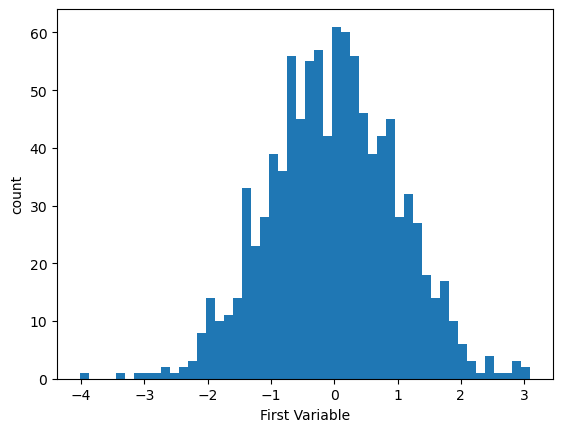

In [6]:
import matplotlib.pyplot as plt

# A simple plot to get an idea of the distribution of the data is a Histogram:
plt.figure()
plt.hist(noise, bins=50)
plt.xlabel("First Variable")
plt.ylabel("count")
plt.show()

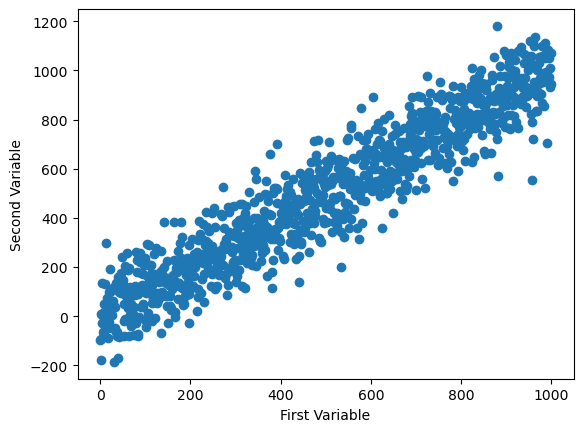

In [7]:
# You will also need the scatter-plot in the Assignment. Make sure to label the axis correctly!
plt.figure()
plt.scatter(line, line_noisy)
plt.xlabel("First Variable")
plt.ylabel("Second Variable")
plt.show()

## Datasets

PyTorch provides two key abstractions for handling data: **Datasets** and **Dataloaders**.

The **Dataset** is the actual container for your data. It provides access to individual data samples and their corresponding labels. 

In P3, the `_torchvision_` library already provided the data in the form of a Dataset. In Assignment 1, however, we are given NumPy arrays. These must first be transformed into a PyTorch-compatible Dataset. One way to do this is shown below:



In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_ds[0]

(tensor([   3.3409,   32.0000,    3.2549,    1.0098,  177.0000,    1.7353,
           33.9000, -118.3700], dtype=torch.float64),
 tensor(2.5630, dtype=torch.float64))

## DataLoader

The second important class for data management in PyTorch is the **DataLoader**. It can be thought of as the *"worker"* that retrieves data from the **Dataset** (the *container*) in a useful and efficient way, such as delivering data in **batches**, **shuffling** the order, and loading in **parallel**.

The `DataLoader` handles:
- **Batching**: Groups samples into mini-batches, which improves training efficiency.
- **Shuffling**: Randomizes the order of samples at the start of each epoch.
- **Parallel loading**: Loads data in the background using multiple worker threads.

Make sure to look at the parameters in the documentation and understand what they do. You can try out different batch_size values. Also think about when shuffling (i.e., getting data in random order) is reasonable!

You can also check out the official PyTorch _Learn the Basics_ Tutorial on this topic: https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [9]:
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers = 4)

In [10]:
# You can use this function to check whether the data transform works:
y_train[y_train < 2] = 0
y_train[y_train >= 2] = 1
np.unique_counts(y_train)

UniqueCountsResult(values=array([0., 1.]), counts=array([8933, 6547]))

In [11]:
# note that above transform modifies your original data. It might be a good idea to create a copy instead, which can be done for example like this:
y_test_bin = np.where(y_test >= 2, 1, 0)
np.unique_counts(y_test_bin)

UniqueCountsResult(values=array([0, 1]), counts=array([2952, 2208]))

## Test Automation

To automatically test different settings, you can have a look at the following code segment. The `product` function helps you get all the different combinations. You will also have to define a training function that can handle the different parameters and adjust your model design to support parameter-dependent configurations.

This can help you learn more about model configuration and using PyTorch. However, you do not need to do this!


In [12]:
from itertools import product


param_grid = {
    "param1": [1, 2],
    "param2": ["a", "b", "c"]
}

results = []
for param1, param2 in product(param_grid["param1"], param_grid["param2"]):
    # You could put your training function here.
    result = {
        "param1": param1,
        "param2": param2,
        "output": f"{2*param1} + {2*param2}"
    }
    results.append(result)


print("\n=== Experiment Results ===")
# Print results in a simple table-like format
for r in results:
    print(f"Param1: {r['param1']:<3} | Param2: {r['param2']:<3} | Output: {r['output']}")



=== Experiment Results ===
Param1: 1   | Param2: a   | Output: 2 + aa
Param1: 1   | Param2: b   | Output: 2 + bb
Param1: 1   | Param2: c   | Output: 2 + cc
Param1: 2   | Param2: a   | Output: 4 + aa
Param1: 2   | Param2: b   | Output: 4 + bb
Param1: 2   | Param2: c   | Output: 4 + cc


For your model to be flexibel in the configuration (hidden layer sizes), have a look at
- [nn.Sequential](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html) or
- [nn.ModuleList](https://docs.pytorch.org/docs/stable/generated/torch.nn.ModuleList.html)

## Loss Function for Classification

In classification tasks, there are multiple options to choose from for the output function and loss function. I will briefly describe the differences here.

### Sigmoid vs. Softmax Output:
If you are distinguishing between only two classes, you can use the *sigmoid* function. It takes a single value (per sample) and squashes it to the range [0, 1]. This models the probability $P(y = \text{class1} \mid X)$ (_the probability that the sample belongs to class 1_). It is redundant to also calculate the probability $P(y = \text{class0} \mid X)$, since for two classes this is simply $1 - P(y = \text{class1} \mid X)$.

If you have more than two classes, the *softmax* function can take one input per class and convert the outputs into probabilities, with the sum of all class probabilities equal to 1.

Further information:
- https://www.geeksforgeeks.org/deep-learning/softmax-vs-sigmoid-activation-function/
- https://www.youtube.com/watch?v=vdXpShCJE1M

### Logits, Probabilities, and Log-Probabilities

There are three terms you will frequently encounter in the documentation of PyTorch loss functions for classification:

- **Logits**: These are the unnormalized outputs of a network, i.e., the output before applying a sigmoid or softmax function. Logits contain the *information* about which class is more likely, but they cannot be directly interpreted as probabilities.

- **Probabilities**: After applying a sigmoid or softmax function, the outputs are in the range [0, 1] and can be directly interpreted as class probabilities.

- **Log-Probabilities**: PyTorch often performs computations using the logarithm of probabilities for numerical stability and efficiency. These are called log-probabilities and can be converted back to probabilities using `torch.exp(log_prob)`.

### The Correct Combinations

- **For binary classification**, refer to the official documentation for the two main loss functions. These explain when to use a sigmoid activation:
  - [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)
  - [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)

- **For multi-class classification**, there are also two common choices:
  - [NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html): As the name _Negative Log Likelihood Loss_ suggests, this function expects **log-probabilities** as input → compatible with `log_softmax`.
  - [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html): Expects **logits** as input → no softmax required at the network output.

Also, make sure to check the documentation to understand the expected format of the target labels (`y`).


## Gradients and Gradient Tracking

Some more notes on functions regarding gradients:

- `with torch.no_grad()` disables gradient tracking in the following code block, which reduces memory usage and speeds up computations during inference. Useful when working with model parameters outside the training loop.
- `model.eval()` sets the model to evaluation mode. This makes a difference for some concepts you maybe haven't learned about (yet), like dropouts or batch norms.
- `model.train()` is the opposite of `model.eval()` and puts the model back in training mode. Ideally, always use those functions before your training / evaluation code.
- Gradients are only tracked when:
  - Tensors have `requires_grad=True`
  - You are not in a `torch.no_grad()` or `torch.inference_mode()` block
  - The model is in training mode


In [13]:
# PyTorch automatically sets the requires_grad of model parameters to True, so you dont have to worry about it, but its still useful to know it exists
import torch.nn as nn

class NeuralNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=28*28, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=10)
      )
      
    def forward(self, x):
      logits = self.stack(x)
      
      return logits
    
mnist_classifier = NeuralNet()

for param in mnist_classifier.parameters():
   print(f"Shape: {param.shape}, requiresg_radient = {param.requires_grad}")

# Other tensors, by default, do not require a gradient
print(f"Input data requires_grad = {X_train_tensor.requires_grad}")


Shape: torch.Size([128, 784]), requiresg_radient = True
Shape: torch.Size([128]), requiresg_radient = True
Shape: torch.Size([10, 128]), requiresg_radient = True
Shape: torch.Size([10]), requiresg_radient = True
Input data requires_grad = False
